<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter03/ch3_nb1_discover_cnns_basic_ops.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 3: Modern Neural Networks</strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">Notebook 1:</small><br/>Discovering CNNs' Basic Operations</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    In this Chapter 3, we presented several new operations and layers which form the core of modern <strong><em>convolutional neural networks (CNNs)</em></strong>. This short notebook illustrates these operations, applying them to a picture.
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [1]:
%matplotlib inline
# !pip install scikit-image   # Uncomment to install this module
# !pip install matplotlib     # Uncomment to install this module
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
from skimage import io        # Package to simply read images

## Setup

Let us first open and display the image we will use as example:

In [2]:
image = io.imread("./res/bird_pic_by_benjamin_planche.png")

Image shape: (680, 608)


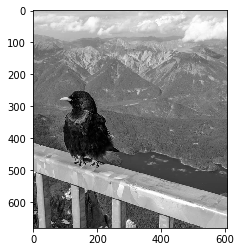

In [3]:
print("Image shape: {}".format(image.shape))
plt.imshow(image, cmap=plt.cm.gray)

To feed this image to TensorFlow operations, we will first convert it into a `Tensor`:

In [4]:
image = tf.convert_to_tensor(image, tf.float32, name="input_image")

As most of the Tensorflow operations are meant for batched images, i.e., of shape $(B, H, W, D)$ we will synthetically *expand* the dimensions of our image, to turn it into a batch of one single image:

In [5]:
image = tf.expand_dims(image, axis=0) # we expand our tensor, adding a dimension at position 0


Similarly, as our image is grayscale and have only one channel, it currently doesn't explicitely have a 4th depth dimension. We correct that by expanding our tensor again:


In [6]:
image = tf.expand_dims(image, axis=-1) # we expand our tensor, adding a dimension at position 0
print("Tensor shape: {}".format(image.shape))

Tensor shape: (1, 680, 608, 1)


## Convolution

As presented in Chapter 2, the basic method for ***image convolution*** in TensorFlow is **`tf.nn.conv2()`**. We will use it to reproduce the Figures 3 and 4 of the chapter.

In Figure 3, we define a $3 \times 3$ filter (or kernel) commonly used to blur images (*Gaussian* blur):

In [7]:
kernel = tf.constant([[1 / 16, 2 / 16, 1 / 16],
                      [2 / 16, 4 / 16, 2 / 16],
                      [1 / 16, 2 / 16, 1 / 16]], tf.float32, name="gaussian_kernel")


However, the convolution method requires the `filter` tensor to be of shape $(k, k, D, N)$ (with $k$ the filter size for square ones, and $N$ the number of filters). Though $D = 1$ and $N = 1$ in our case, we still need to reshape our kernel to explicitely express those values:

In [8]:
kernel = tf.expand_dims(tf.expand_dims(kernel, axis=-1), axis=-1)

To *filter* the image with our kernel, it is now just a matter of calling `tf.nn.conv2()`:


In [9]:
blurred_image = tf.nn.conv2d(image, kernel, strides=[1, 1, 1, 1], padding="SAME")

By default in _eager_ mode with TensorFlow 2, we can directly recover the result of the operation:

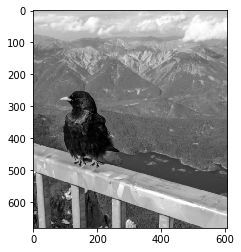

In [10]:
blurred_res = blurred_image.numpy()
# We "unbatch" our result by selecting the first (and only) image; we also remove the depth dimension:
blurred_res = blurred_res[0, ..., 0]

plt.imshow(blurred_res, cmap=plt.cm.gray)

Observing the bird's feathers or the landscape'S details, we can see how blurred the image slightly became.

In Figure 4, a kernel for ***contour detection*** is used. This kernel is defined as follows:

In [11]:
kernel = tf.constant([[-1, -1, -1],
                      [-1,  8, -1],
                      [-1, -1, -1]], tf.float32, name="edge_kernel")
kernel = tf.expand_dims(tf.expand_dims(kernel, axis=-1), axis=-1)

This time, we use a larger stride to demonstrate how this affects the resulting tensors:

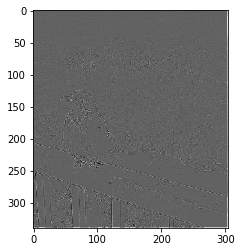

In [12]:
edge_image = tf.nn.conv2d(image, kernel, strides=[1, 2, 2, 1], padding="SAME")
edge_res = edge_image.numpy()[0, ..., 0]
plt.imshow(edge_res, cmap=plt.cm.gray)

If you look closely, the image has a white border. This is caused by the zero-padding (since we chose padding `"SAME"`), detected as a contour by the kernel. Indeed, it disappears if we don't pad the image:

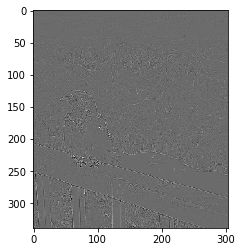

In [13]:
edge_image = tf.nn.conv2d(image, kernel, strides=[1, 2, 2, 1], padding="VALID")
edge_res = edge_image.numpy()[0, ..., 0]
plt.imshow(edge_res, cmap=plt.cm.gray)

## Pooling

For ***max-pooling*** and ***average-pooling***, the values in each window are aggregated into a single output, applying respectively the max or averaging operation. Once again, we use the low-level TensorFlow API to reproduce the results shown in the chapter:

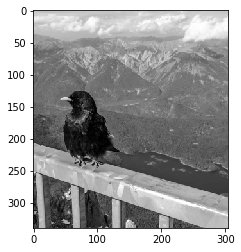

In [14]:
avg_pooled_image = tf.nn.avg_pool(image, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
avg_res = avg_pooled_image.numpy()[0, ..., 0]
plt.imshow(avg_res, cmap=plt.cm.gray)

With these _hyper-parameters_, the average pooling divided each dimension of the input image by 2.

Now performing the max-pooling:

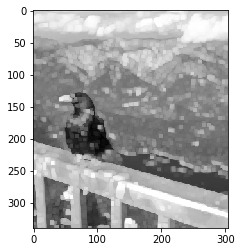

In [15]:
max_pooled_image = tf.nn.max_pool(image, ksize=[1, 10, 10, 1], strides=[1, 2, 2, 1], padding="SAME")
max_res = max_pooled_image.numpy()[0, ..., 0]
plt.imshow(max_res, cmap=plt.cm.gray)

Using an excessively large kernel size, we can see how the operation assignes the largest value per window. 

### Conclusion

Adding these operations to the fully-connected layer presented earlier, we now have the tools to build our first CNN - which will be the topic of the next notebook.